# Variational Quantum Eigensolver

#### Uncomment the cell below to pip install the necessary modules if not already installed

#### Note: Works with Qiskit Version 1.4.1 and Quantum Rings Qiskit Toolkit Version 0.1.10

In [1]:
# %pip install numpy
# %pip install qiskit==1.4.1
# %pip install qiskit-ibm-runtime
# %pip install matplotlib
# %pip install QuantumRingsLib
# %pip install quantumrings-toolkit-qiskit==0.1.10

#### Restart the kernel after installing any of the missing packages

### Introduction

[Variational Quantum Algorithms](https://arxiv.org/abs/2012.09265) are promising candidate hybrid-algorithms for observing quantum computation utility on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". Chief among these methods is the Variational Quantum Eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms, with an ansatz circuit where the number of parameters to optimize over is polynomial in the number of qubits. Given that the size of the full solution vector is exponential in the number of qubits, successful minimization using VQE requires, in general, additional problem-specific information to define the structure of the ansatz circuit.

Executing a VQE algorithm requires the following components:

1. Hamiltonian and ansatz (problem specification)
2. Qiskit Runtime Estimator
3. Classical Optimizer

Although the Hamiltonian and ansatz require domain-specific knowledge to construct, these details are immaterial to the Runtime, and we can execute a wide class of VQE problems in the same manner.

In this notebook, we will go through the process of executing a VQE algorithm. Our problem will be based on a quantum chemistry problem, thus our Hamiltonian will be derived from this problem. We will start by mapping the classical inputs to the quantum problem. We then optimize the problem for quantum execution. Once optimized, we will execute our algorithm using Quantum Rings Qiskit Toolkit Estimator alongside IBM Runtimes `Session`. Finally, when we have our results we will perform some post-processing procedures to return them in a classical format.

In [2]:
# Where to find this code?
# https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

### Map classical inputs to a quantum problem

The problem instance in question for the VQE algorithm can come from a variety of domains, the form for execution through Qiskit Runtime is the same. Qiskit provides a convenience class for expressing Hamiltonians in Pauli form, and a collection of widely used ansatz circuits in the `qiskit.circuit.library`. We will use this to build the circuit, and instead of using Qiskits Runtime, we will use Quantum Rings Toolkit for the `backend` and `estimator`. We'll start with importing the necessary tools for a VQE experiment and then build our Hamiltonian.

In [3]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2 # Used for the ansatz
from qiskit.quantum_info import SparsePauliOp # Used for the Hamiltonian

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

The cell below will instantiate the Quantum Rings backend. It assumes you have saved your Quantum Rings account locally with the call to `QuantumRingsProvider()`. If you have not saved your account, please see the documentation on [how to save your account locally](https://portal.quantumrings.com/doc/SavingAccountLocally.html).

In [4]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session

import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from quantumrings.toolkit.qiskit import QrEstimatorV2 as Estimator

provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits = 2)


In [5]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

Our choice of ansatz is the `EfficientSU2` that linearly entangles qubits by default, making it ideal for quantum hardware with limited connectivity. There are many other circuits available for use as an ansatz in the `QuantumCircuit` class. Feel free to check out [other circuit implementations](https://docs.quantum.ibm.com/api/qiskit/circuit_library#n-local-circuits).

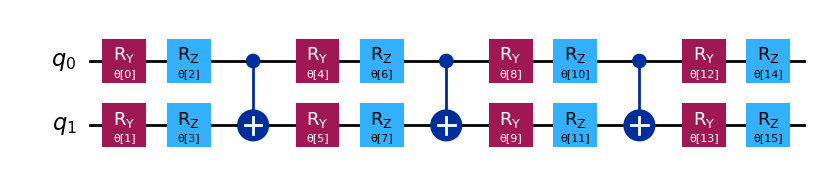

In [6]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

From the previous figure, we see that our ansatz circuit is defined by a vector of parameters, $\theta_i$, with the total number printed in the cell below.

In [7]:
num_params = ansatz.num_parameters
num_params

16

### Optimize the problem for quantum execution

To reduce the total job execution time, Qiskit primitives only accept circuits (ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the target QPU (referred to as Instruction Set Architecture (ISA) circuits and observables).

**ISA Circuit**

We will schedule a series of `qiskit.transpiler` passes to optimize the circuit for a selected backend and make it compatible with the backend's ISA. This can be easily done with a preset pass manager from `qiskit.transpiler` and its `optimization_level` parameter.

The lowest optimization level does the minimum needed to get the circuit running on the device. It maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

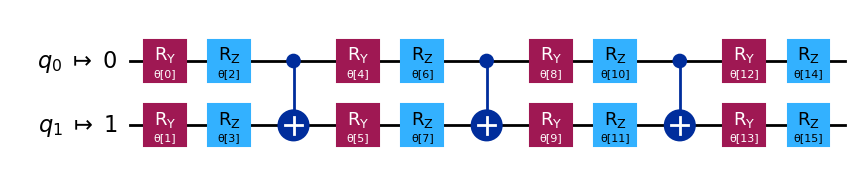

In [9]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

**ISA Observable**

We will transform the Hamiltonian to make it backend-compatible before running jobs with `QrEstimatorV2`. We can perform the transformation by using the `apply_layout` method of the `SparsePauliOp` object.

In [10]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

### Execute using Qiskit Primitives

Similar to classical optimization problems, the solution to a VQE problem can be formulated as a minimization of a scalar cost function. By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian. With the `Estimator` directly taking a Hamiltonian and a parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple.

> **Note**: The `run()` method of `QrEstimatorV2` takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format `(circuit, observables, parameter_values: Optional, precision: Optional)`.

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    
  
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

> **Note** In addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function, such as the `cost_history_dict`. This dictionary stores the current vector at each iteration, for example in case you need to restart the routine due to failure, and also returns the current iteration number and average time per iteration.

In [12]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

We can now use a classical optimizer of our choice to minimize the cost function. Here, we use the [COBYLA method from SciPy designated through the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). 

> **Note**: When running on real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well. 

To begin the routine, we specify a random set of initial parameters.

In [13]:
x0 = 2 * np.pi * np.random.random(num_params)

In [14]:
x0

array([1.39073602, 3.53353088, 4.18525351, 3.68888843, 0.37672397,
       4.02126056, 2.11092837, 3.26754609, 3.61488044, 5.39857328,
       2.30645609, 2.00058347, 5.24033097, 5.3223852 , 3.9246684 ,
       3.57480222])

Because we are sending a large number of jobs that we would like to execute together, we use a `Session` to execute all the generated circuits in one block. Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.

In [15]:
with Session(backend=backend) as session:
    estimator = Estimator(backend=backend)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: [0.07589816534116267]]
Iters. done: 2 [Current cost: [-0.13956480959555545]]
Iters. done: 3 [Current cost: [-0.07893674227775964]]
Iters. done: 4 [Current cost: [-0.05290740650883577]]
Iters. done: 5 [Current cost: [-0.24671899452974633]]
Iters. done: 6 [Current cost: [0.02039527099596187]]
Iters. done: 7 [Current cost: [-0.2937767647505366]]
Iters. done: 8 [Current cost: [-0.11044150853805312]]
Iters. done: 9 [Current cost: [-0.4249718708393174]]
Iters. done: 10 [Current cost: [-0.5037410640010741]]
Iters. done: 11 [Current cost: [-0.35812200705007]]
Iters. done: 12 [Current cost: [-0.4348801124184594]]
Iters. done: 13 [Current cost: [-0.336469441504349]]
Iters. done: 14 [Current cost: [-0.6342214121174233]]
Iters. done: 15 [Current cost: [-0.4513354262142346]]
Iters. done: 16 [Current cost: [-0.611048951235178]]
Iters. done: 17 [Current cost: [-0.44908994213863346]]
Iters. done: 18 [Current cost: [-0.5763474495391198]]
Iters. done: 19 [Current cost: [-0.

At the end of this routine we have a result in the standard SciPy `OptimizeResult` format. From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.

In [16]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7029303903124833
       x: [ 2.420e+00  3.473e+00 ...  4.237e+00  3.414e+00]
    nfev: 243
   maxcv: 0.0

### Post-process: Return the result in classical format

If the procedure terminates correctly, then the `prev_vector` and `iters` values in our `cost_history_dict` dictionary should be equal to the solution vector and total number of function evaluations, respectively. We can verify this in the cell below.

In [17]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [18]:
cost_history_dict["iters"] == res.nfev

True

We can view the progress toward convergence as monitored by the cost history at each iteration:

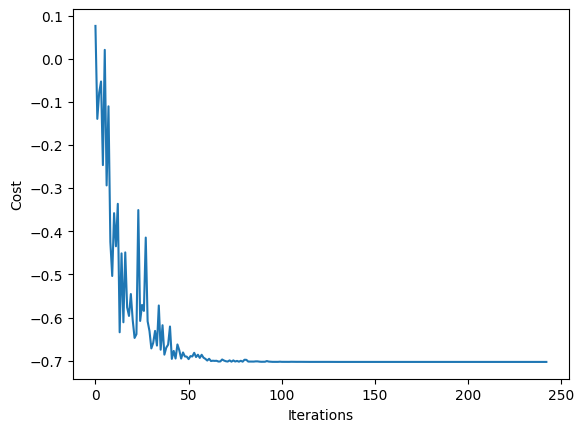

In [19]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

### Conclusion

Congratulations! You've programmed a Variational Quantum Eigensolver for a small molecular quantum chemistry problem! In this notebook, you covered a small background on VQEs and how to implement them given a Hamiltonian. You created an ansatz circuit with variational parameters to then convert the problem from a classical format to a quantum format which is compatible with a quantum circuit. Using a classical optimizer, the variational parameters for the objective function of the circuit were calculated. You then converted the result of these circuit estimations back in to a classical format to see the convergence process of the objective function.